In [5]:
# packages
import numpy as np  # matrix and vector operations
import matplotlib.pyplot as plt  # visualization
#import fssa as fssa  # scaling collapse 
from utils import *  # all things ID of MBL
from time import time
import glob
import numpy.ma as ma
from plotting import *
import scipy as sp
import seaborn as sns
from tqdm import tqdm

import matplotlib as mpl
fig_size_dim    = 4
golden_ratio    = (1+np.sqrt(5))/2
fig_size        = (fig_size_dim, fig_size_dim/golden_ratio)

def plot_style():
    font_size       = 12
    dpi             = 200

    params = {'figure.figsize': fig_size,
              'figure.dpi': dpi,
              'savefig.dpi': dpi,
              'font.size': font_size,
              'font.family': "sans-serif",
              'font.sans-serif': ["Helvetica"],
              'figure.titlesize': font_size,
              'legend.fontsize': font_size,
              'axes.labelsize': font_size,
              'axes.titlesize': font_size,
              'xtick.labelsize': font_size,
              'ytick.labelsize': font_size,
              'text.usetex': False,
             }

    plt.rcParams.update(params)
plot_style()

In [2]:
## Global variables
# List of available system sizes
Ls = [8, 10, 12, 14, 16]#, 18]
# List of available disorder strengths
Ws = np.concatenate([np.arange(1,2.6,0.2), np.arange(2.6,4.55,0.05), np.arange(4.7,6.2,0.2)])

# Download data
# TODO (curl from ERDA)

## Eigenvector dominance

In [122]:
from utils import *

result = {}
tmp_ws = np.logspace(0,2,100)
for L in [8,10,12,14]:
    result[L] = []
    for seed in range(5):
        max_amplitude = []
        for W in tqdm(tmp_ws):
            H = constructHamiltonian(L = L, W = W, U = 1.0, t = 1.0, seed=seed)
            _, eigvecs = np.linalg.eigh(H)    
            max_amplitude.append(np.mean(np.sum(np.abs(eigvecs), axis=0)))
        result[L].append(max_amplitude)
        
#np.save("eigenvector_components.npy", result)

100%|██████████| 100/100 [04:43<00:00,  2.84s/it]


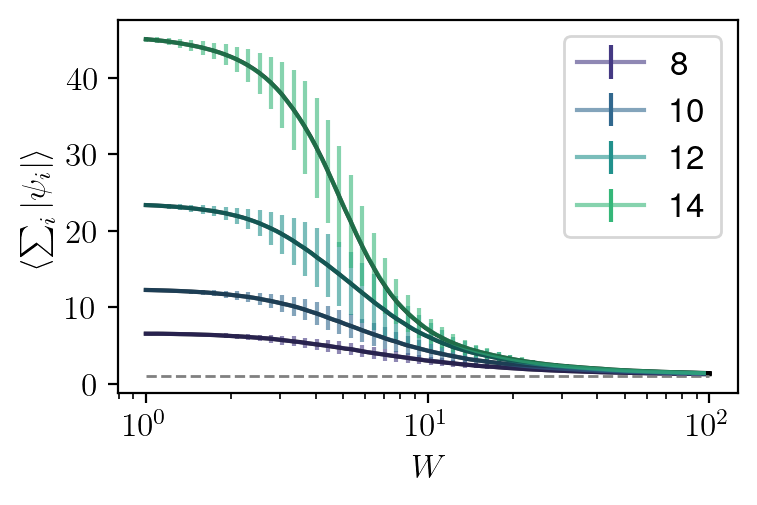

In [15]:
fig, ax = plt.subplots(figsize=fig_size)

result = np.atleast_2d(np.load("eigenvector_components.npy", allow_pickle=True))[0][0]

tmp_ws = np.logspace(0,2,100)
colors = sns.color_palette("viridis", len(Ls))
for c,L in zip(colors,[8,10,12,14]):
    ax.errorbar(tmp_ws[::2], np.mean(result[L], axis=0)[::2], yerr=np.std(result[L], axis=0)[::2], alpha=0.6, c=c, label=L)
    ax.plot(tmp_ws, np.mean(result[L], axis=0), c='k')
    
ax.plot([1,1e2], [1,1], '--', c='gray', linewidth=1)
#ax.set_yticks([1,10,20,30,40])
ax.set_xscale('log')
ax.set_xlabel('$W$')
ax.set_ylabel('$ \\langle \sum_i | \psi_i | \\rangle$')
legend = ax.legend(fancybox=True)
for lh in legend.legendHandles:
    lh.set_alpha(1)
    
fig.savefig("EigenvectorComponents.pdf", bbox_inches='tight')

## Averages

In [172]:
# Gather data
files = {}
for L in Ls:
    files[L] = []
    files[L] = glob.glob("cluster_data/2nn_L_{0}/*".format(L))
    print("For L = {0}, {1} seeds are available".format(L, len(files[L])))

For L = 8, 101000 seeds are available
For L = 10, 10100 seeds are available
For L = 12, 5010 seeds are available
For L = 14, 1001 seeds are available
For L = 16, 1000 seeds are available
For L = 18, 10 seeds are available


In [174]:
def load_IDs(L, Ws, seeds):
    ID = -1*np.ones((len(seeds),len(Ws)))
    rsquared = -1*np.ones((len(seeds),len(Ws)))
    
    count = 0
    missing = []
    for seed in seeds:
        try:
            data = np.atleast_2d(np.load("cluster_data/2nn_L_{0}/2nn_L_{0}_seed_{1}.npy".format(L,seed), allow_pickle=True))[0]
            ID[seed] = np.array([data[i]['ID'] for i in range(len(Ws))])
            rsquared[seed] = np.array([data[i]['rsquared'] for i in range(len(Ws))])
        except Exception as e:
            print(seed, e)
            missing.append(seed)
            continue
            
    ID = ma.masked_equal(ID, -1)
    rsquared = ma.masked_equal(rsquared, -1)
    print("Loaded {0} out of {1} seeds".format(len(seeds)-len(missing), len(seeds)))
    
    if missing:
        print("Missing seed nrs: ")
        print(missing)
        
    return ID, rsquared

In [175]:
IDs = {}
rsquareds = {}

In [176]:
for L in Ls[:-1]:
    print("Loading data for L = {0}...".format(L))
    IDs[L], rsquareds[L] = load_IDs(L, Ws, range(0, len(files[L])))
    print("Done!")

Loading data for L = 8...
Loaded 101000 out of 101000 seeds
Done!
Loading data for L = 10...
Loaded 10100 out of 10100 seeds
Done!
Loading data for L = 12...
Loaded 5010 out of 5010 seeds
Done!
Loading data for L = 14...
Loaded 1001 out of 1001 seeds
Done!
Loading data for L = 16...
Loaded 1000 out of 1000 seeds
Done!


## Nearest Neighbor distance distribution functions

In [177]:
bins_upper = dict({8:10,10:20,12:35,14:70,16:160,18:350})

def normal(x, a,sigma, mu):
    return a/(sigma*(2*np.pi)**0.5) * np.exp(-.5*((x-mu)/sigma)**2)

hists = {}
mu = {}
sigma = {}
bins = {}
for L in Ls:
    hists[L] = {}
    mu[L] = {}
    sigma[L] = {}
    
    bins[L] = np.linspace(0,bins_upper[L],50)
    
    for i,W in tqdm(enumerate(Ws)):
        histogram = 0
        for seed in range(np.min([1000,len(files[L])])):
            data = np.atleast_2d(np.load("cluster_data/2nn_L_{0}/2nn_L_{0}_seed_{1}.npy".format(L,seed), allow_pickle=True))[0]
            h, binedges = np.histogram(data[i]['nndist'], bins=bins[L], density=True)
            histogram += h
        hists[L][W] = histogram

        y = histogram
        x = bins[L][:-1]
        popt, pcov = sp.optimize.curve_fit(normal, x,y, maxfev=10000, p0=[5000,4,15])
        mu[L][W] = popt[2]
        sigma[L][W] = popt[1]

55it [00:30,  1.83it/s]
55it [00:32,  1.70it/s]
55it [00:48,  1.14it/s]
55it [01:10,  1.28s/it]
55it [10:12, 11.14s/it]
37it [00:07,  5.27it/s]


IndexError: index 37 is out of bounds for axis 0 with size 37

[4.499999999999993, 4.049999999999995, 3.8999999999999955, 3.8499999999999956, 3.9499999999999953, 3.999999999999995]


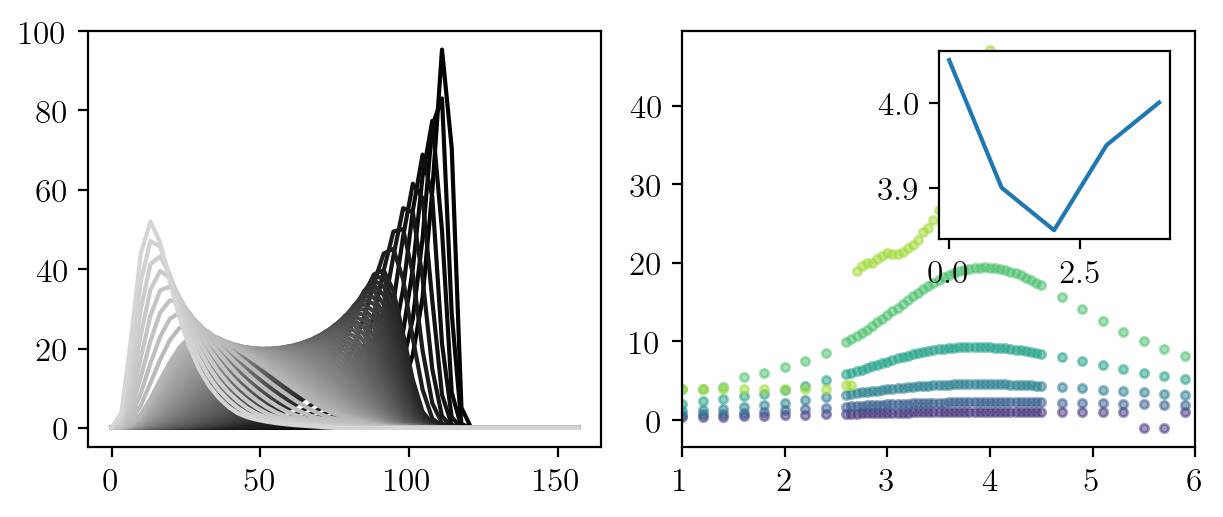

In [185]:
fig, ax = plt.subplots(1,2, figsize=(6, 4/golden_ratio), constrained_layout=True)

colors = sns.color_palette("gray", 10+len(Ws))
for c, W in zip(colors, Ws):
    ax[0].plot(bins[16][:-1], hists[16][W], c=c)

colors = sns.color_palette("viridis", len(Ls))
sigma_peaks = []
for c,L in zip(colors,Ls):
    ax[1].plot(sigma[L].keys(),sigma[L].values(), 'o', label=L, markersize=3, alpha=.5, c=c)
    sigma_peaks.append(np.array(list(sigma[L].keys()))[np.argmax(np.array(list(sigma[L].values())))])
#ax[1].legend(fancybox=True)

ax[1].set_xlim([1,6])
axin = ax[1].inset_axes([0.5, 0.5, 0.45, 0.45])
print(sigma_peaks)
axin.plot(sigma_peaks[1:])

[16.          0.20855682  0.          1.59074393]
[25.          0.35488234  0.86650819  2.3860363 ]
[36.          0.59369472  3.28199256  3.08640534]
[52.48241905  0.98638155  9.49820017  3.4825083 ]
[85.4198505  1.2       10.5        3.8      ]


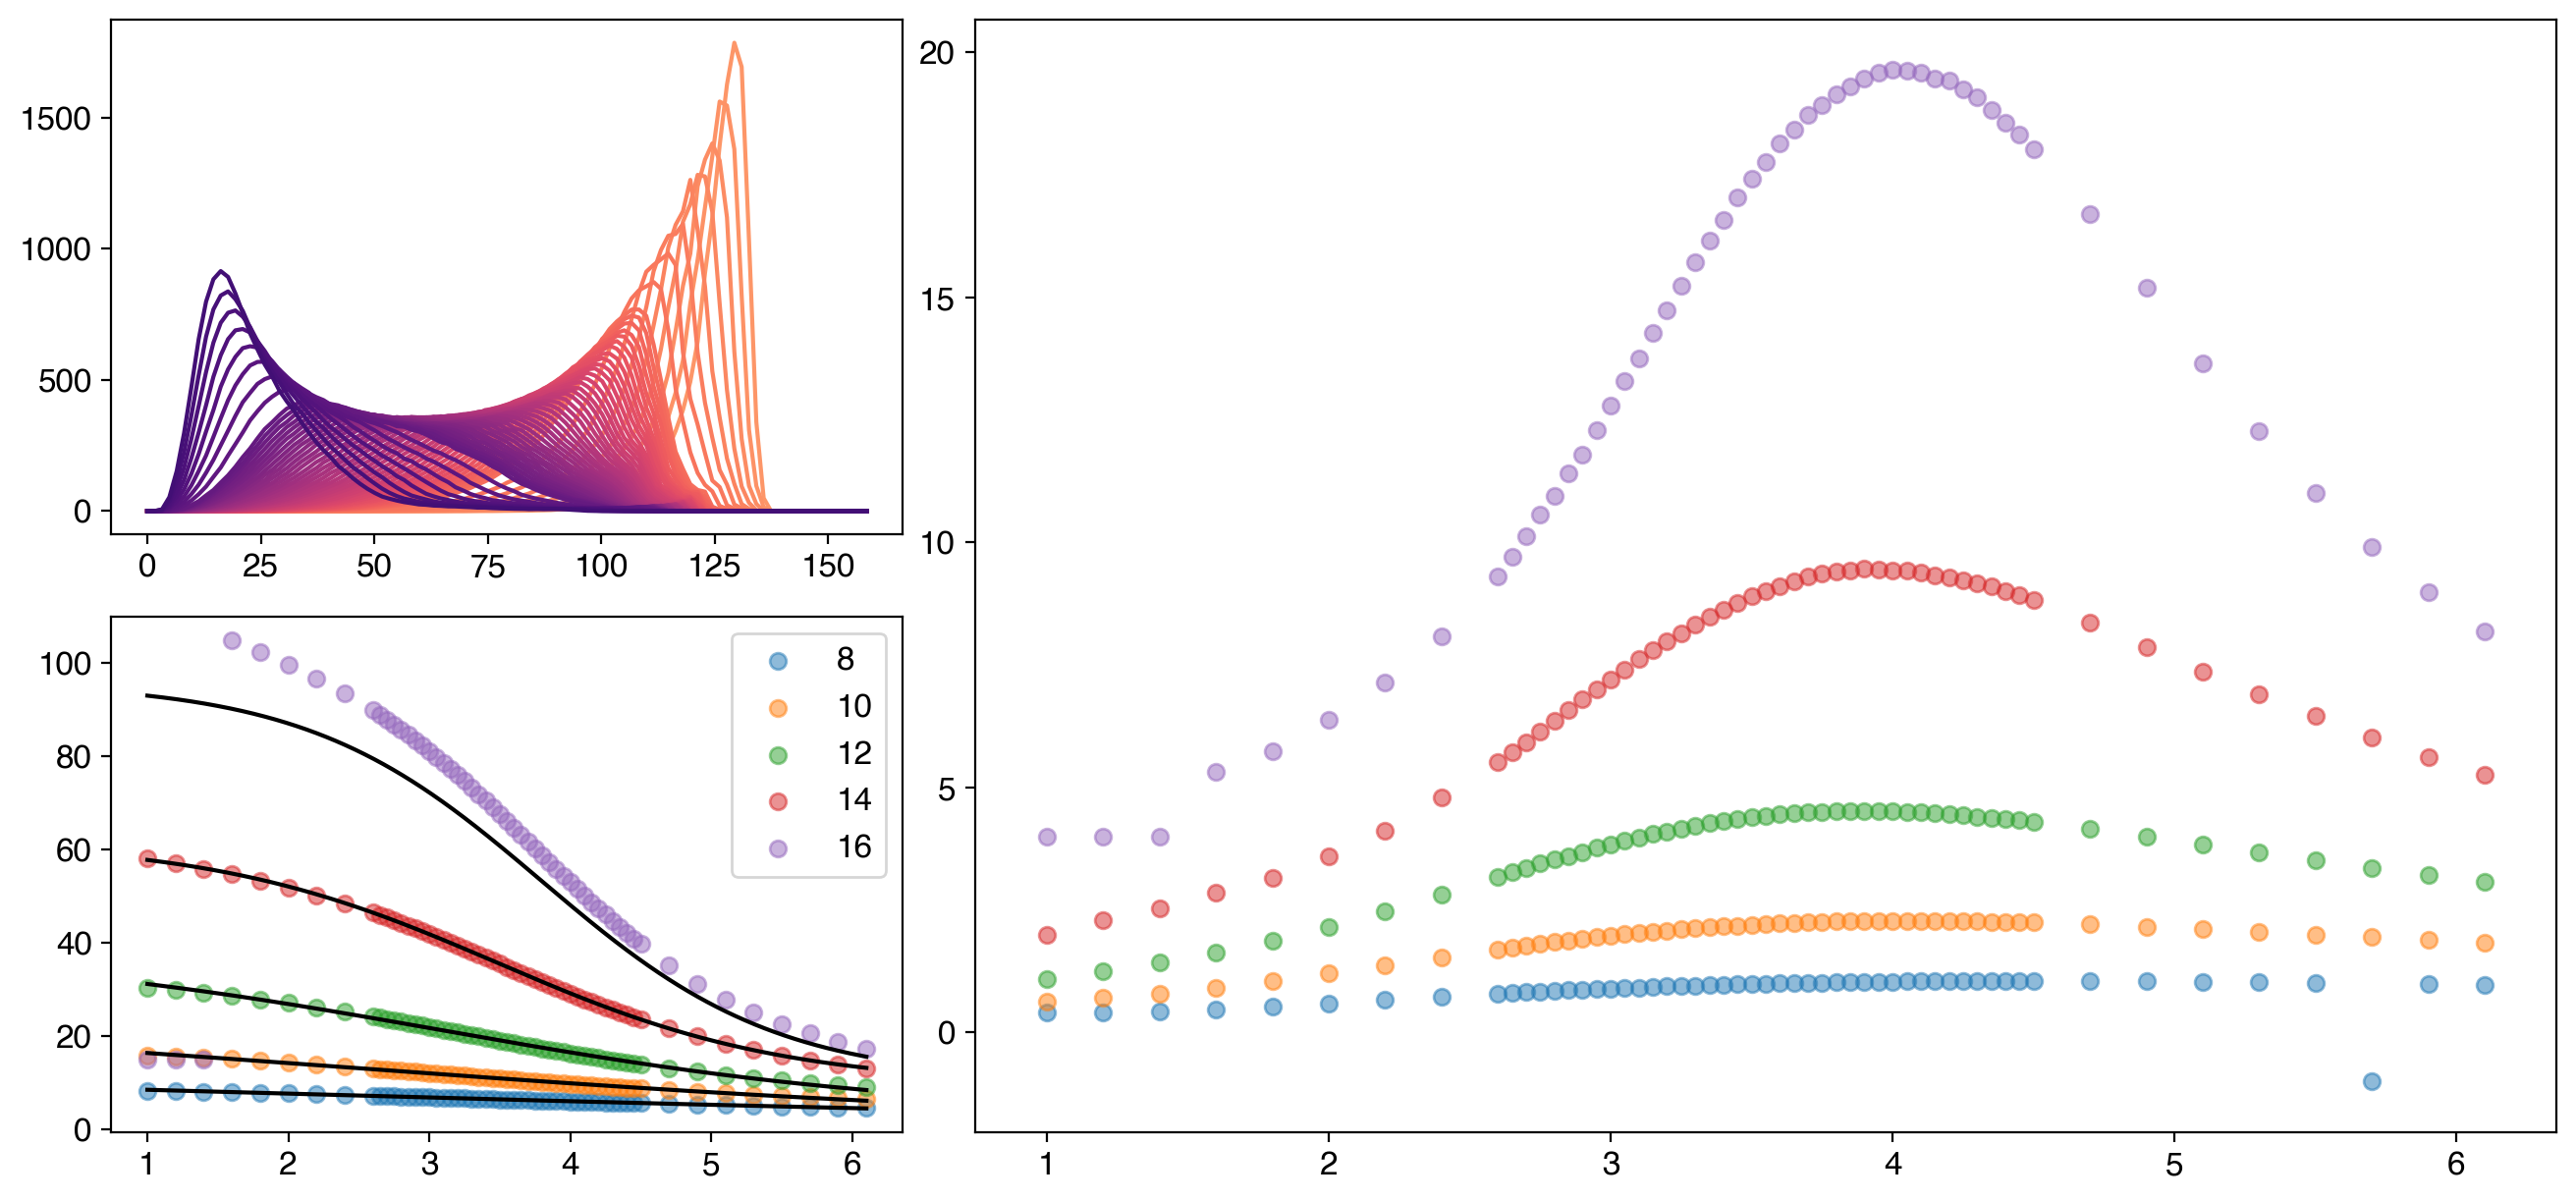

In [11]:
file = np.load('main_hist_dict_1.npz', allow_pickle=True)
main_dict = file[file.files[0]].item()

fig = plt.figure(figsize=(13, 6), constrained_layout=True)
spec = fig.add_gridspec(ncols=3, nrows=2)

ax0 = fig.add_subplot(spec[0,:1])
ax1 = fig.add_subplot(spec[1,:1])
ax2 = fig.add_subplot(spec[:,1:])

bins_upper = dict({8:10,10:20,12:35,14:70,16:160,18:350})
import seaborn as sns

from scipy.optimize import curve_fit

colors = sns.color_palette("magma_r", 40+len(Ws))[20:-20]
sigma_peaks, mu_0, mu_0_err = [], [], []

data=main_dict


def logistic(x,a,k, b, x_0):
    return a/(1+np.exp(k*(x-x_0))) +b


for c, W in zip(colors, Ws):
    ax0.plot(np.linspace(0,bins_upper[16],100)[:-1], data[16]['hists'][W]/100, c=c)


for L in [8,10,12,14,16]:
    ##mu
    mu_keys = np.array(list(data[L]['mu'].keys()))
    mu_vals = np.array(list(data[L]['mu'].values()))
    ax1.scatter(mu_keys,mu_vals, label=L, alpha=.5)
    
    
    popt, pcov = curve_fit(logistic, mu_keys, mu_vals, 
                           p0=[L**2/3 ,  1.16810418  ,2 ,  3.64967613],
                           bounds = ([L**2/4,0,0,0] , [L**2/2,1.2,10.5,3.8]),
                            method='dogbox', maxfev=20000
                          )
    print(popt)

    
    xdata = np.linspace(min(mu_keys),max(mu_keys), 10000)
    ydata = logistic(xdata, *popt)
    ax1.plot(xdata,logistic(xdata, *popt), c='black')

    ## sigma
    sigma_keys = np.array(list(data[L]['sigma'].keys()))
    sigma_vals = np.array(list(data[L]['sigma'].values()))
    ax2.scatter(sigma_keys,sigma_vals, label=L, alpha=.5)
    
    
[ax.legend() for ax in [ax1]]#,ax01,ax02]]

plt.show()




## 2NN to estimate ID
2NN is a neighbour graph algo. which determines the intrinsic dimension of a dataset -- when applied to a list of eigenvectors corresponding to one realization of a single disorder strength.

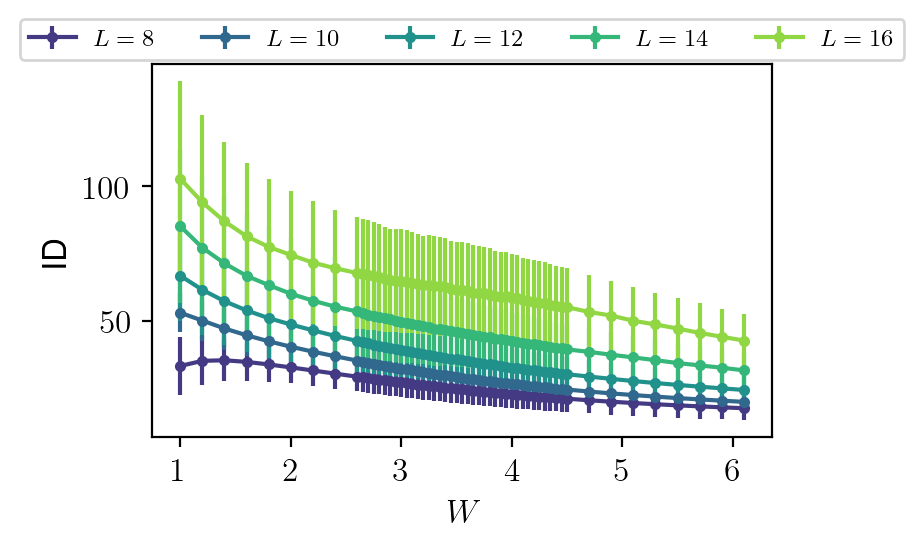

In [191]:
averaged_ID = {}
for L in Ls:
    averaged_ID[L] = ma.sum(IDs[L]*rsquareds[L],axis=0)/ma.sum(rsquareds[L],axis=0)

fig, ax = plt.subplots()

colors = sns.color_palette("viridis", len(Ls))
for c,L in zip(colors,Ls):
    ax.errorbar(Ws, averaged_ID[L], yerr=ma.std(IDs[L]*rsquareds[L],axis=0), marker='o', ms=3, c=c, label="$L={}$".format(L))

ax.set_xlabel("$W$")
ax.set_ylabel("ID")
ax.legend(fancybox=True, loc='upper center', fontsize='x-small', ncol=5, bbox_to_anchor=(0.5, 1.15))

scale_Ls = [10,12,14,16,18]
scale_Ws = [2.8,4.2]
W_start = np.argwhere(Ws>=scale_Ws[0])[0][0]
W_end = np.argwhere(Ws>=scale_Ws[1])[0][0]
scale_Ws = Ws[W_start:W_end]

# a = np.array([averaged_ID[L][W_start:W_end] for L in scale_Ls])
# auto_scaled_data = fssa.scaledata(scale_Ls, scale_Ws, a, a*0.1, 3.6, 1, 1)
# ret = fssa.autoscale(scale_Ls, scale_Ws, a, a*0.1, 3.8, -0.5, -0.5)

# axin = ax.inset_axes([0.5, 0.5, 0.45, 0.45])
# for i,L in enumerate(scale_Ls):
#     axin.plot(auto_scaled_data.x[i], auto_scaled_data.y[i], '.', markersize=1, c=colors[i+1])

## Plateauing

In [ ]:
import os, sys
sys.path.insert(1, os.path.join(sys.path[0], './cluster_scripts'))
from utils_cluster import nn2

def plateau(L, seed):
    # Fixed high disorder to confirm ID ~> L
    W = 20

    H = constructHamiltonian(L = L, W = W, seed=seed)
    _, eigvecs = np.linalg.eigh(H)

    ID_vs_fraction = {}
    num_averages = 5
    for fraction in tqdm([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]):
        ID_vs_fraction[fraction] = []
        for a in range(num_averages):
            # Take 'fraction' many eigenstates, random and uniformly
            sample = np.random.choice(range(len(eigvecs)), int(fraction*len(eigvecs)))
            sample = eigvecs[:,sample]
            
            # Compute ID for this sample
            ID, rsquared, nndist = nn2(sample)
            ID_vs_fraction[fraction].append([ID,rsquared])
    
    return ID_vs_fraction

In [ ]:
data = plateau(10, 1)

In [ ]:
fractions = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
means = []
for fraction in fractions:
    m = np.mean(data[fraction], axis=0)
    means.append(m)

plt.plot(fractions, means)

## Playground

## Alternative scaling

Our central goal is to find the best data collapse of $ID(W, L)$ and $r_1(W, L)$ as functions of $L/ξ$

In [202]:
def x_BKT(W, W_c, b):
    return np.exp(b/np.sqrt(abs(W-W_c)))

def x_0(W, W_c, nu):
    return abs(W-W_c)**(-nu)

In [203]:
def cost_func(X):
    numerator = sum([abs(X[i+1] - X[i]) for i in range(len(X)-1)]) 
    denominator = max(X)-min(X)
    cost = numerator/denominator -1
    return cost

For a given functional form of the correlation length ξ
and the critical disorder W∗
[which is included in the
functional form of ξ, see Eqs. (1) and (2)], we then
sort numerical values of S and r at different W and
L ∈ {12, 14, 16, 18, 20} according to nondecreasing L/ξ.

In [208]:
from scipy.optimize import differential_evolution

def collapse(Ls, Ws, X, correlation_func):
    
    def scale(p):
        w0 = p[0]
        w1 = p[1]
        b = p[2]
        zeta = p[3]
        
        def W_c(L):
            return w0 + w1*L
        
        def xi(L):
            return correlation_func(Ws, W_c(L), b)
        
         # Create a list of all values of sign(W-W*) * L / xi (for a given choice of xi and W_c)
        x = np.array([ np.sign(Ws-W_c(L)) * L / xi(L) for L in Ls]).flatten()   
        
        # For each W and L, scale according to nondecreasing sign(W-W*) * L / xi
        sorted_indices = np.argsort(x)[::-1]
        # Transform our inputs to follow the same sorting 
        y = np.array([ X[L]/X[L][0] for L in Ls ]).flatten()
        y = y[sorted_indices]*L**(-zeta)
        return cost_func(y)
    
    ret = differential_evolution(scale, x0 = [0.5, 0.01, 0.4, 0.5],popsize=100,
                                 bounds=[(0,6.0),(0,2.0),(0,3),(0,2)])#, strategy='best2exp')
    
    return ret

In [216]:
averaged_ID = {}
for L in Ls:
    averaged_ID[L] = ma.sum(IDs[L]*rsquareds[L],axis=0)/ma.sum(rsquareds[L],axis=0)

scale_Ls = [12,14,16]
scale_Ws = [2.8,4.2]
W_start = np.argwhere(Ws>=scale_Ws[0])[0][0]
W_end = np.argwhere(Ws>=scale_Ws[1])[0][0]
scale_Ws = Ws[W_start:W_end]

ret = collapse(scale_Ls, scale_Ws, averaged_ID, x_BKT )
#ret = collapse(Ls, Ws, averaged_ID, x_BKT )
print(ret)

     fun: 1.5928690740805624
 message: 'Optimization terminated successfully.'
    nfev: 1205
     nit: 2
 success: True
       x: array([2.93720402, 1.43597912, 0.38959305, 0.99131108])


In [217]:
ret['x']

array([2.93720402, 1.43597912, 0.38959305, 0.99131108])

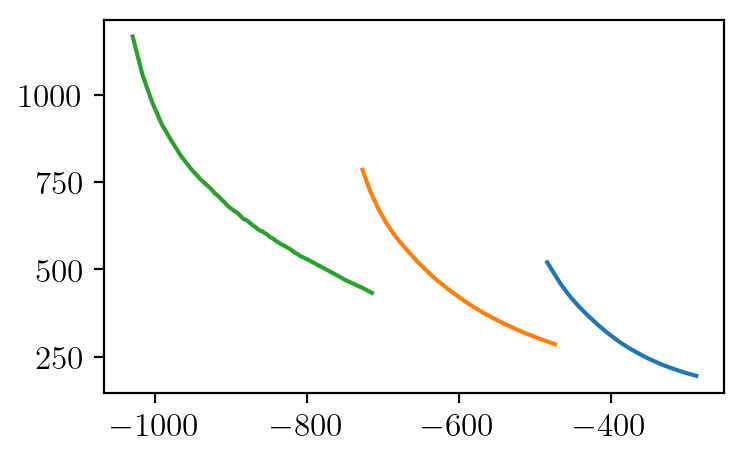

In [218]:
def rescale(ID, L, p):
    w0 = p[0]
    w1 = p[1]
    b = p[2]
    zeta = p[3]

    def W_c(L):
        return w0 + w1*L
    
    xi = x_0(Ws, W_c(L), b)
    x = (Ws-W_c(L)) * L / xi
    y = ID*L**(zeta)
    
    
    return x,y

x, y = rescale(averaged_ID[10], 10, ret['x'])
plt.plot(x,y)
x, y = rescale(averaged_ID[12], 12, ret['x'])
plt.plot(x,y)
x, y = rescale(averaged_ID[14], 14, ret['x'])
plt.plot(x,y)

We apply a differential evolution method implemented
in scipy to find the optimal set of free parameters of ξ
and W∗
that minimize the cost function. 
In each realization, we employ a population size 102 and allow for up to
103
iterations. 
We use the relative tolerance of convergence 10−2 and employ 102
realizations of the algorithm
to verify the precision of fitted parameters of the optimal
solution.


In the main text (see Tables I and II) we compared cost
functions with the functional form of the critical disorder W∗ = w0 [one free parameter], W∗ = w0 + w1L [two
free parameters] and W∗ = w
∗
(L) [five free parameters
for five different L]. Here we complement those results
by focusing on two-parameter functional forms W∗ = w0 + w1/L and W∗ = w0 + w1/ ln(L). These two functions imply finite critical disorder W∗ = w0 in the thermodynamic limit L → ∞. Results for the optimal cost
function are compared to the results for the functional
form with a linear drift with L, i.e., W∗ = w0 + w1L, see
Tables S1 and S2. The main result is that the functional
form of the critical disorder W∗ always yields a lower
cost function if a linear drift with L is allowed. Moreover, in the case of a linear drift the solution using the
KT correlation length ξKT is always substantially better.
In other cases, there is no considerable difference in cost
functions between solutions using ξKT or ξ0.

$ \xi_{KT} = \exp{ \frac{b_{\pm}}_{\sqrt{|W − W∗|}} } $

$ξ_0 = 1/|W − W∗|^ν$ 